<a href="https://colab.research.google.com/github/spentaur/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [384]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [386]:
df.isna().sum() / len(df) * 100

BOROUGH                             0.000000
NEIGHBORHOOD                        0.000000
BUILDING_CLASS_CATEGORY             0.000000
TAX_CLASS_AT_PRESENT                0.004340
BLOCK                               0.000000
LOT                                 0.000000
EASE-MENT                         100.000000
BUILDING_CLASS_AT_PRESENT           0.004340
ADDRESS                             0.000000
APARTMENT_NUMBER                   77.426215
ZIP_CODE                            0.004340
RESIDENTIAL_UNITS                   0.004340
COMMERCIAL_UNITS                    0.004340
TOTAL_UNITS                         0.004340
LAND_SQUARE_FEET                    0.000000
GROSS_SQUARE_FEET                   0.004340
YEAR_BUILT                          0.151910
TAX_CLASS_AT_TIME_OF_SALE           0.000000
BUILDING_CLASS_AT_TIME_OF_SALE      0.000000
SALE_PRICE                          0.000000
SALE_DATE                           0.000000
dtype: float64

# predict property sales prices for One Family Dwellings `(BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS')` using a subset of the data where the `sale price was more than $100 thousand and less than $2 million`.

# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
def split():
    # Read New York City property sales data
    df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

    # Change column names: replace spaces with underscores
    df.columns = [col.replace(' ', '_') for col in df]

    # SALE_PRICE was read as strings.
    # Remove symbols, convert to integer
    df['SALE_PRICE'] = (
        df['SALE_PRICE']
        .str.replace('$','')
        .str.replace('-','')
        .str.replace(',','')
        .astype(int)
    )
    df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
    df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.extract('(\d+)').fillna(0).astype(int)

    january = '2019-01-01'
    march = '2019-03-31'
    april = '2019-04-30'


    train_conditions = ((df['SALE_DATE'] >= january) & 
                        (df['SALE_DATE'] < april))

    test_conditions = (df['SALE_DATE'] == april)

    conditions = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
                    (df['SALE_PRICE'] > 100000) & 
                    (df['SALE_PRICE'] < 2000000))



    train = df[conditions & train_conditions].copy()
    test = df[conditions & test_conditions].copy()
    train = train.dropna(thresh=len(train)*0.6,axis=1)
    test = test.dropna(thresh=len(test)*0.6,axis=1)
    train = train.drop(["BUILDING_CLASS_CATEGORY", 'SALE_DATE'], axis=1)
    test = test.drop(['BUILDING_CLASS_CATEGORY', 'SALE_DATE'], axis=1)
    return train,test

In [0]:
train,test = split()

In [393]:
train.select_dtypes('object').columns

Index(['NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

# Do exploratory visualizations with Seaborn.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

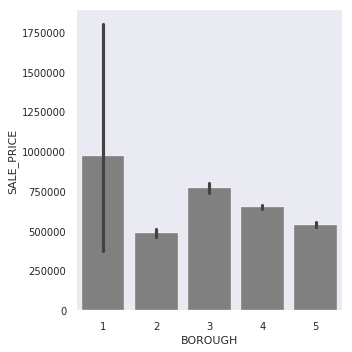

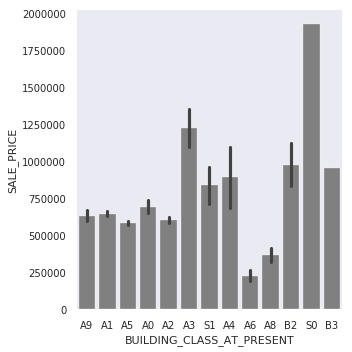

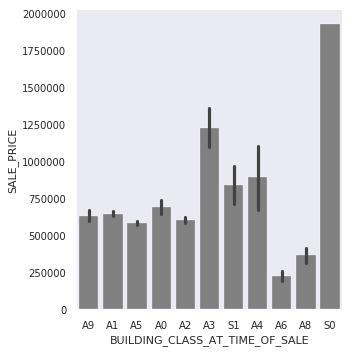

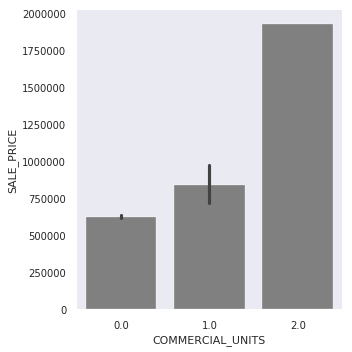

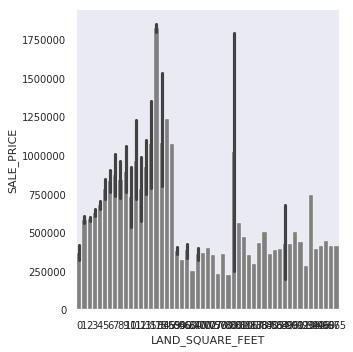

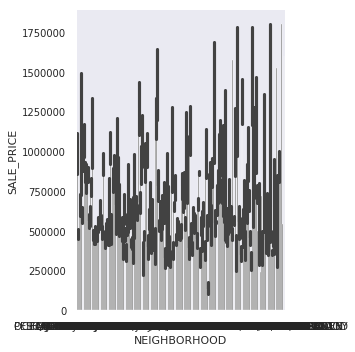

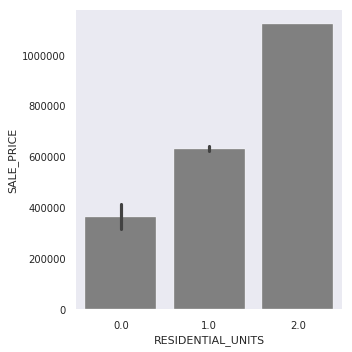

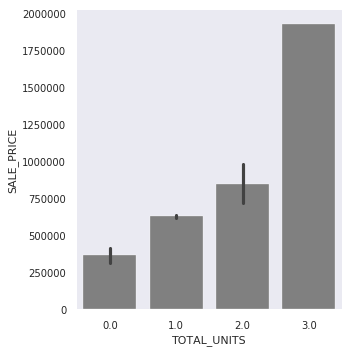

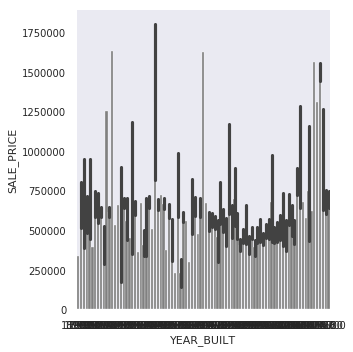

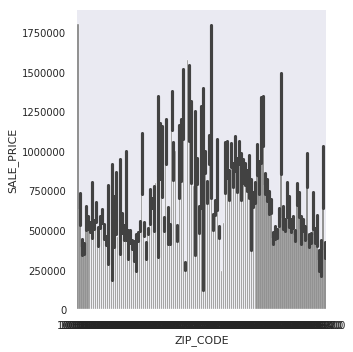

In [394]:
sns.set_style('dark')

for col in sorted(train.columns):
    if 2 < train[col].nunique() < 200:
        sns.catplot(x=col, y='SALE_PRICE', data = train, kind = 'bar', color = 'grey')
        plt.show()

# Do one-hot encoding of categorical features.

In [169]:
train.select_dtypes('object').columns

Index(['NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'LAND_SQUARE_FEET', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
import category_encoders as ce
cats = ['NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE']
encoder = ce.OneHotEncoder(use_cat_names=True)
train_encoded = encoder.fit_transform(train[cats])
test_encoded = encoder.transform(test[cats])

test = test.drop(cats, axis=1)
train = train.drop(cats, axis=1)

test = pd.concat([test, test_encoded], axis=1, sort=False)
train = pd.concat([train, train_encoded], axis=1, sort=False)

# Do feature selection with SelectKBest.

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

In [0]:
features = train.select_dtypes(include=['number', 'bool']).columns.drop('SALE_PRICE')

In [345]:
kbest = SelectKBest(score_func=f_regression, k = 20)
train_selected = kbest.fit_transform(train[features], train['SALE_PRICE'])

train_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(3125, 20)

In [346]:
selected_mask = kbest.get_support()
selected_features = features[selected_mask]
unselected_features = features[~selected_mask]

print('Features selected:')
for num, name in enumerate(selected_features):
    print(num + 1, name)

Features selected:
1 BLOCK
2 ZIP_CODE
3 RESIDENTIAL_UNITS
4 COMMERCIAL_UNITS
5 TOTAL_UNITS
6 GROSS_SQUARE_FEET
7 NEIGHBORHOOD_MADISON
8 NEIGHBORHOOD_MIDWOOD
9 NEIGHBORHOOD_BAYSIDE
10 NEIGHBORHOOD_FLUSHING-NORTH
11 NEIGHBORHOOD_FOREST HILLS
12 NEIGHBORHOOD_WHITESTONE
13 NEIGHBORHOOD_BAY RIDGE
14 NEIGHBORHOOD_BOROUGH PARK
15 NEIGHBORHOOD_SUNSET PARK
16 NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN
17 TAX_CLASS_AT_PRESENT_1
18 BUILDING_CLASS_AT_PRESENT_A3
19 BUILDING_CLASS_AT_TIME_OF_SALE_A3
20 BUILDING_CLASS_AT_TIME_OF_SALE_A8


In [347]:
selected_features

Index(['BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'NEIGHBORHOOD_MADISON',
       'NEIGHBORHOOD_MIDWOOD', 'NEIGHBORHOOD_BAYSIDE',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_WHITESTONE', 'NEIGHBORHOOD_BAY RIDGE',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_SUNSET PARK',
       'NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN', 'TAX_CLASS_AT_PRESENT_1',
       'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8'],
      dtype='object')

# Fit a linear regression model with multiple features.

In [348]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(train[selected_features], train['SALE_PRICE'])



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Get mean absolute error for the test set.

In [0]:
from sklearn.metrics import mean_absolute_error

test_pred = model.predict(test[selected_features])

In [350]:
selected_features

Index(['BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'NEIGHBORHOOD_MADISON',
       'NEIGHBORHOOD_MIDWOOD', 'NEIGHBORHOOD_BAYSIDE',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_WHITESTONE', 'NEIGHBORHOOD_BAY RIDGE',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_SUNSET PARK',
       'NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN', 'TAX_CLASS_AT_PRESENT_1',
       'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8'],
      dtype='object')

In [351]:
mean_absolute_error(test['SALE_PRICE'], test_pred)

164204.30573362342

In [352]:
(mean_absolute_error(test['SALE_PRICE'], test_pred) / test['SALE_PRICE'].mean()) * 100

23.603308672695945

# Turn it into a function

In [0]:
def train_and_test(train, test, model=LinearRegression(), target='SALE_PRICE'):
    # check for cardinality
    train_unique = train.select_dtypes(exclude=['number', 'bool']).nunique()
    test_unique = test.select_dtypes(exclude=['number', 'bool']).nunique()
    cardinality = (train_unique > 200) | (test_unique > 200)
    low_cardinality = ~cardinality
    high_cardinality = cardinality

    features_to_encode = train.select_dtypes(exclude=['number', 'bool']).columns[low_cardinality].tolist()
    # ['NEIGHBORHOOD','TAX_CLASS_AT_PRESENT','BUILDING_CLASS_AT_PRESENT','BUILDING_CLASS_AT_TIME_OF_SALE','SALE_DATE']
    features_to_drop = train.select_dtypes(exclude=['number', 'bool']).columns[high_cardinality].tolist()
    # ['ADDRESS']

    # encode low cardinal categorical features
    encoder = ce.OneHotEncoder(use_cat_names=True)
    X_train_encoded = encoder.fit_transform(train[features_to_encode])
    X_test_encoded = encoder.transform(test[features_to_encode])

    # drop the original encoded features, and add the encoded ones
    train_copy = train.drop(features_to_encode + features_to_drop + [target], axis=1)
    test_copy = test.drop(features_to_encode + features_to_drop + [target], axis=1)

    # combine encoded and train / test
    train_copy = pd.concat([train_copy, X_train_encoded], axis=1)
    test_copy = pd.concat([test_copy, X_test_encoded], axis=1)

    X_train = train_copy
    y_train = train[target]

    X_test = test_copy
    y_test = test[target]

    best = {}

    for k in range(1, len(X_test.columns) + 1):
        kbest = SelectKBest(score_func=f_regression, k=k)
        X_train_selected = kbest.fit_transform(X_train, y_train)
        X_test_selected = kbest.transform(X_test)

        selected_mask = kbest.get_support()
        selected_features = X_test.columns[selected_mask]

        model.fit(X_train_selected, y_train)

        y_pred = model.predict(X_test_selected)
        mae = mean_absolute_error(y_test, y_pred)

        best[mae] = {
            'model': model,
            'selected_features': selected_features,
            'mae': mae,
            'mae_in_terms_of_mean': (mae / test[target].mean()) * 100
        }

    return best[sorted(best)[0]]

In [0]:
train,test = split()
best = train_and_test(train, test, LinearRegression())

In [398]:
best

{'mae': 140701.33653846153,
 'mae_in_terms_of_mean': 20.224908610896122,
 'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'selected_features': Index(['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
        'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
        'GROSS_SQUARE_FEET', 'YEAR_BUILT',
        ...
        'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
        'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
        'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
        'BUILDING_CLASS_AT_TIME_OF_SALE_S0'],
       dtype='object', length=120)}